USE SMOTE

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/another_dementia_dataset (1).csv")

# Drop unnecessary IDs
df = df.drop(columns=["Subject ID", "MRI ID", "Visit"])

# Encode target
df["Group"] = df["Group"].map({"Nondemented":0, "Demented":1, "Converted":1})  # Converted treated as Demented
y = df["Group"].values.astype(int)
X = df.drop("Group", axis=1).copy()

# Define feature groups
num_features = ["Age","EDUC","SES","MMSE","CDR","MR Delay","eTIV","nWBV","ASF"]
cat_features = ["M/F","Hand"]

# ======================================
# STEP 2: Helper Functions (DL models)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Numeric: impute + scale
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    # Categorical: impute + one-hot
    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # Balance with SMOTE
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # Train + evaluate
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        results_ml.append([name, fold, acc, prec, rec, f1])

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("=== ML Models Performance (mean over 5 folds) ===")
print(results_ml.groupby("Model").mean())

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Imputation + scaling (same as ML)
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # Balance with SMOTE
    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_bal, validation_split=0.2,
            epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_pred = (hnn.predict(X_test_f, verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_bal,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_pred = (cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("\n=== DL Models Performance (mean over 5 folds) ===")
print(results_dl.groupby("Model").mean())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
              Fold  Accuracy  Precision    Recall        F1
Model                                                      
GaussianNB     2.0  0.943676   0.976200  0.907057  0.939588
KNN            2.0  0.914090   0.967649  0.852102  0.905176
MLP            2.0  0.938378   0.956716  0.918018  0.935138
RandomForest   2.0  0.951784   0.982571  0.918168  0.948207
SVM            2.0  0.946414   0.988143  0.901652  0.942154



=== DL Models Performance (mean over 5 folds) ===
                 Fold  Accuracy  Precision    Recall        F1
Model                                                         
CNN+Transformer   2.0  0.782811   0.789489  0.764414  0.774035
HNN               2.0  0.938378   0.966439  0.907057  0.934482


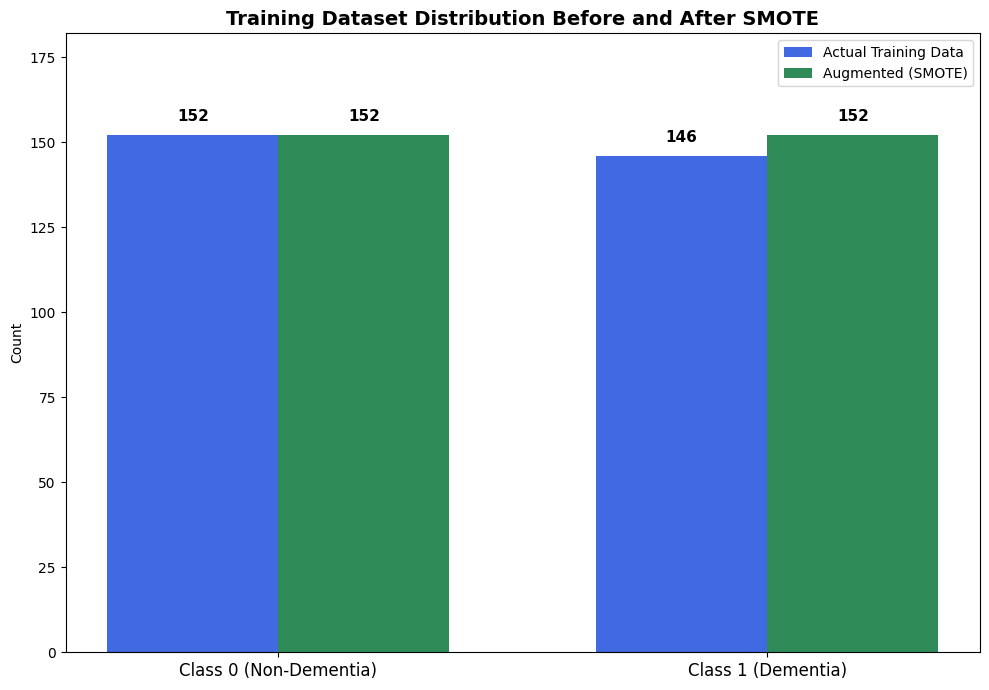

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take first fold to illustrate distribution
train_idx, test_idx = next(skf.split(X, y))
X_train, y_train = X.iloc[train_idx].copy(), y[train_idx]

# === Preprocess same as training pipeline ===
num_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))

cat_mode = X_train[cat_features].mode().iloc[0]
X_train_cat = X_train[cat_features].fillna(cat_mode)
ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train_cat)

# Combine
X_train_f = np.hstack([X_train_num, X_train_ohe])

# === Class distribution before SMOTE ===
before_counts = pd.Series(y_train).value_counts().sort_index()

# === Apply SMOTE ===
sm = SMOTE(random_state=42)
X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

# === Class distribution after SMOTE ===
after_counts = pd.Series(y_train_bal).value_counts().sort_index()

# ===== Plot =====
labels = ["Class 0 (Non-Dementia)", "Class 1 (Dementia)"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, before_counts, width, label="Actual Training Data", color="royalblue")
rects2 = ax.bar(x + width/2, after_counts, width, label="Augmented (SMOTE)", color="seagreen")

ax.set_ylabel("Count")
ax.set_title("Training Dataset Distribution Before and After SMOTE", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

# Adjust y-axis with padding
max_count = max(before_counts.max(), after_counts.max())
ax.set_ylim(0, max_count + int(0.2*max_count))

# Add text above bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,8),  # offset above
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()


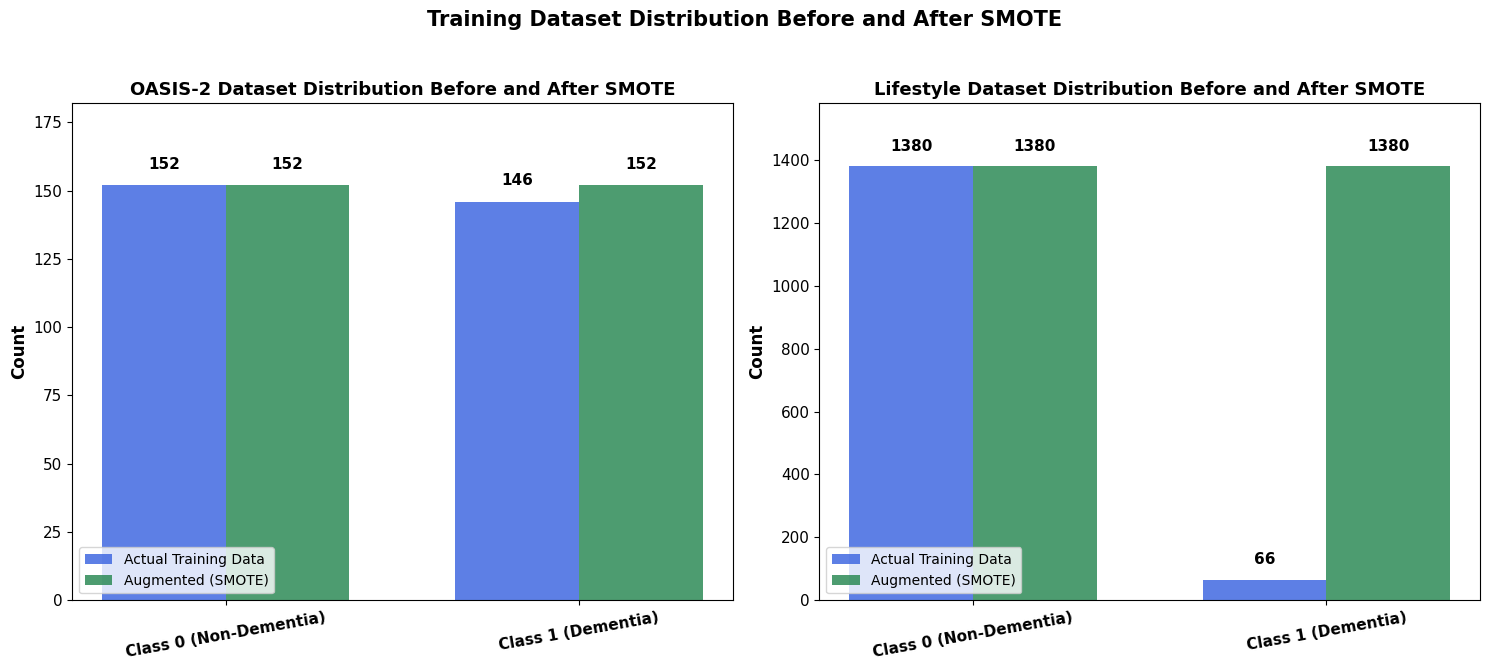

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Data for corrected OASIS-2
# ===============================
classes = ["Class 0 (Non-Dementia)", "Class 1 (Dementia)"]
actual_counts_oasis = [152, 146]
smote_counts_oasis = [152, 152]

# ===============================
# Data for Lifestyle Dataset
# ===============================
actual_counts_life = [1380, 66]
smote_counts_life = [1380, 1380]

# ===============================
# Plot setup
# ===============================
x = np.arange(len(classes))  # the label locations
width = 0.35  # bar width

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# -------------------------------
# Left subplot (OASIS-2)
# -------------------------------
rects1 = axes[0].bar(x - width/2, actual_counts_oasis, width,
                     label='Actual Training Data', color='royalblue', alpha=0.85)
rects2 = axes[0].bar(x + width/2, smote_counts_oasis, width,
                     label='Augmented (SMOTE)', color='seagreen', alpha=0.85)

axes[0].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[0].set_title("OASIS-2 Dataset Distribution Before and After SMOTE",
                  fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes, fontsize=11, fontweight='bold', rotation=10)
axes[0].tick_params(axis='y', labelsize=11)
axes[0].legend(loc='lower left', fontsize=10)

# Add counts on top of bars
for rect in rects1 + rects2:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., height + 5,
                 '%d' % int(height), ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

# Increase y-limit
axes[0].set_ylim(0, max(max(actual_counts_oasis), max(smote_counts_oasis)) + 30)

# -------------------------------
# Right subplot (Lifestyle dataset)
# -------------------------------
rects3 = axes[1].bar(x - width/2, actual_counts_life, width,
                     label='Actual Training Data', color='royalblue', alpha=0.85)
rects4 = axes[1].bar(x + width/2, smote_counts_life, width,
                     label='Augmented (SMOTE)', color='seagreen', alpha=0.85)

axes[1].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[1].set_title("Lifestyle Dataset Distribution Before and After SMOTE",
                  fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes, fontsize=11, fontweight='bold', rotation=10)
axes[1].tick_params(axis='y', labelsize=11)
axes[1].legend(loc='lower left', fontsize=10)

# Add counts on top of bars
for rect in rects3 + rects4:
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width()/2., height + 40,
                 '%d' % int(height), ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

# Increase y-limit
axes[1].set_ylim(0, max(max(actual_counts_life), max(smote_counts_life)) + 200)

# -------------------------------
# Main Title
# -------------------------------
fig.suptitle("Training Dataset Distribution Before and After SMOTE",
             fontsize=15, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


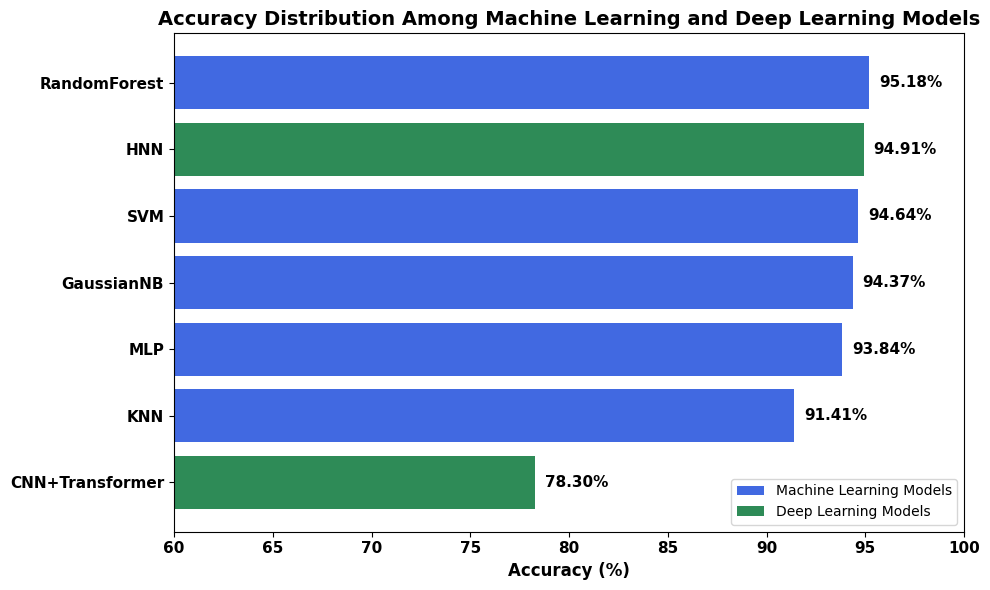

In [ ]:
import matplotlib.pyplot as plt

# === Aggregate mean accuracy across folds ===
ml_summary = results_ml.groupby("Model")["Accuracy"].mean()
dl_summary = results_dl.groupby("Model")["Accuracy"].mean()

# Combine results
all_results = pd.concat([ml_summary, dl_summary])
model_types = {m:"ML" for m in ml_summary.index}
model_types.update({m:"DL" for m in dl_summary.index})

# Sort by accuracy
all_results = all_results.sort_values(ascending=False)

# === Plot ===
plt.figure(figsize=(10,6))
colors = ["royalblue" if model_types[m]=="ML" else "seagreen" for m in all_results.index]
bars = plt.barh(all_results.index, all_results.values*100, color=colors)

# Bold labels & title
plt.xlabel("Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("Accuracy Distribution Among Machine Learning and Deep Learning Models",
          fontsize=14, fontweight="bold")

# Make y-tick labels bold
plt.yticks(fontsize=11, fontweight="bold")
plt.xticks(fontsize=11, fontweight="bold")

# Add values to bars (bold text)
for bar, value in zip(bars, all_results.values*100):
    plt.text(bar.get_width()+0.5, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}%", va="center", fontsize=11, fontweight="bold")

# Legend (bold text)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor="royalblue", label="Machine Learning Models"),
                   Patch(facecolor="seagreen", label="Deep Learning Models")]
plt.legend(handles=legend_elements, loc="lower right", fontsize=10, frameon=True)

plt.xlim(60, 100)  # match your figure’s range
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


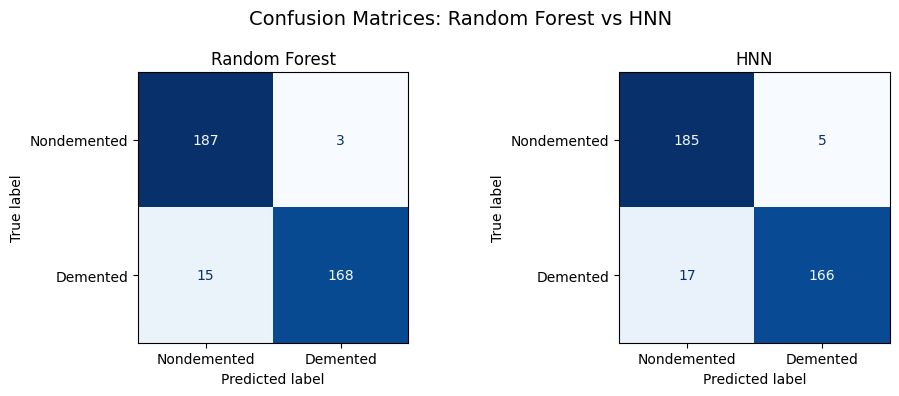

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ======================================
# STEP 5: Collect OOF predictions for RF and HNN
# ======================================
oof_preds_rf = np.zeros(len(y), dtype=int)
oof_preds_hnn = np.zeros(len(y), dtype=int)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # === Preprocessing (same as before) ===
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    sm = SMOTE(random_state=42)
    X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

    # === Random Forest ===
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train_f_bal, y_train_bal)
    oof_preds_rf[test_idx] = rf.predict(X_test_f)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_bal, validation_split=0.2,
            epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_pred_hnn = (hnn.predict(X_test_f, verbose=0).ravel() > 0.5).astype(int)
    oof_preds_hnn[test_idx] = y_pred_hnn

# ======================================
# STEP 6: Confusion Matrices in One Figure
# ======================================
cm_rf = confusion_matrix(y, oof_preds_rf)
cm_hnn = confusion_matrix(y, oof_preds_hnn)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Nondemented", "Demented"])
disp_rf.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Random Forest")

# HNN
disp_hnn = ConfusionMatrixDisplay(confusion_matrix=cm_hnn, display_labels=["Nondemented", "Demented"])
disp_hnn.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("HNN")

plt.suptitle("Confusion Matrices: Random Forest vs HNN", fontsize=14)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


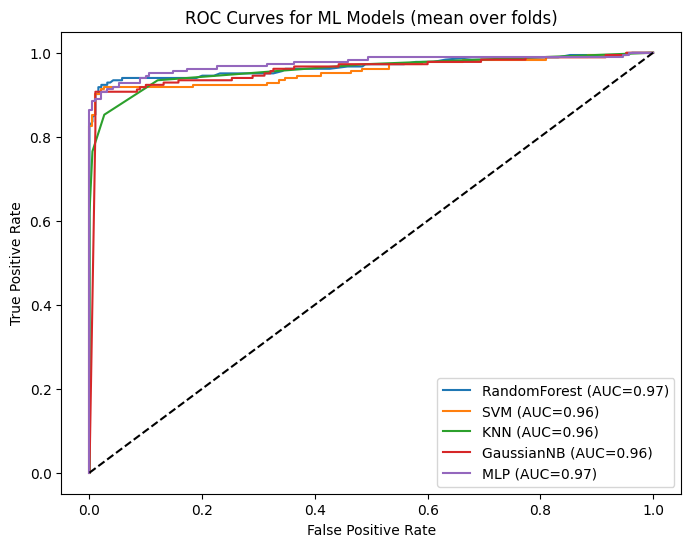

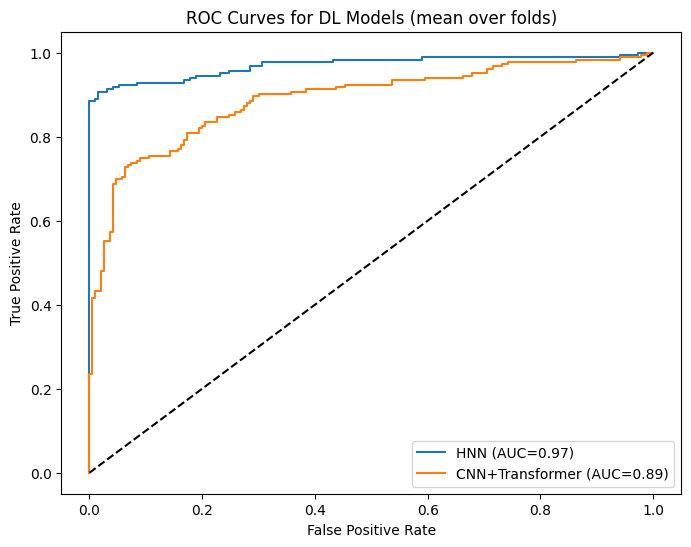

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ======================================
# ROC Curve for ML Models (averaged)
# ======================================
plt.figure(figsize=(8,6))

for name, model in ml_models.items():
    y_true_all, y_prob_all = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y[train_idx], y[test_idx]

        # === Preprocessing (same as above) ===
        num_imputer = SimpleImputer(strategy="mean")
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
        X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

        cat_mode = X_train[cat_features].mode().iloc[0]
        X_train_cat = X_train[cat_features].fillna(cat_mode)
        X_test_cat  = X_test[cat_features].fillna(cat_mode)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_cat)
        X_test_ohe  = ohe.transform(X_test_cat)

        X_train_f = np.hstack([X_train_num, X_train_ohe])
        X_test_f  = np.hstack([X_test_num,  X_test_ohe])

        sm = SMOTE(random_state=42)
        X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

        # Train model
        model.fit(X_train_f_bal, y_train_bal)

        # Predict probabilities
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_f)[:,1]
        else:
            y_prob = model.decision_function(X_test_f)

        # Collect
        y_true_all.extend(y_test)
        y_prob_all.extend(y_prob)

    # Final averaged ROC
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves for ML Models (mean over folds)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# ======================================
# ROC Curve for DL Models (averaged)
# ======================================
plt.figure(figsize=(8,6))

for dl_name in ["HNN", "CNN+Transformer"]:
    y_true_all, y_prob_all = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y[train_idx], y[test_idx]

        # === Preprocessing ===
        num_imputer = SimpleImputer(strategy="mean")
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
        X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

        cat_mode = X_train[cat_features].mode().iloc[0]
        X_train_cat = X_train[cat_features].fillna(cat_mode)
        X_test_cat  = X_test[cat_features].fillna(cat_mode)
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
        X_train_ohe = ohe.fit_transform(X_train_cat)
        X_test_ohe  = ohe.transform(X_test_cat)

        X_train_f = np.hstack([X_train_num, X_train_ohe])
        X_test_f  = np.hstack([X_test_num,  X_test_ohe])

        sm = SMOTE(random_state=42)
        X_train_f_bal, y_train_bal = sm.fit_resample(X_train_f, y_train)

        es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

        if dl_name == "HNN":
            model = build_hnn(X_train_f_bal.shape[1])
            model.fit(X_train_f_bal, y_train_bal, validation_split=0.2,
                      epochs=30, batch_size=32, callbacks=[es], verbose=0)
            y_prob = model.predict(X_test_f, verbose=0).ravel()

        else:  # CNN+Transformer
            model = build_cnn_transformer(X_train_f_bal.shape[1])
            model.fit(np.expand_dims(X_train_f_bal,-1), y_train_bal,
                      validation_split=0.2, epochs=30, batch_size=32,
                      callbacks=[es], verbose=0)
            y_prob = model.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel()

        # Collect
        y_true_all.extend(y_test)
        y_prob_all.extend(y_prob)

    # Final averaged ROC
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{dl_name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves for DL Models (mean over folds)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
df['Group'].value_counts()

,count
Group,
0,190
1,183


With Gaussian augmentation

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/another_dementia_dataset (1).csv")

# Drop unnecessary IDs
df = df.drop(columns=["Subject ID", "MRI ID", "Visit"])

# Encode target (Converted treated as Demented)
df["Group"] = df["Group"].map({"Nondemented":0, "Demented":1, "Converted":1})
y = df["Group"].values.astype(int)
X = df.drop("Group", axis=1).copy()

# Define feature groups
num_features = ["Age","EDUC","SES","MMSE","CDR","MR Delay","eTIV","nWBV","ASF"]
cat_features = ["M/F","Hand"]

# ======================================
# STEP 2: Helper Functions (DL builders + augmentation)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Gaussian augmentation helper
def gaussian_augment(X, y, noise_std=0.05, factor=1.0):
    """Augments minority class with Gaussian noise"""
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    X_aug, y_aug = [X], [y]
    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        n_needed = int((max_count - counts[cls]) * factor)
        if n_needed > 0:
            samples = X[cls_idx]
            noise = np.random.normal(0, noise_std, size=(n_needed, X.shape[1]))
            synthetic = samples[np.random.choice(len(samples), n_needed, replace=True)] + noise
            X_aug.append(synthetic)
            y_aug.append(np.full(n_needed, cls))
    return np.vstack(X_aug), np.hstack(y_aug)

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Imputation & scaling for numeric
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    # One-hot encoding for categorical
    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # Gaussian augmentation
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    # Train + evaluate
    for name, model in ml_models.items():
        model.fit(X_train_f_bal, y_train_bal)
        y_pred = model.predict(X_test_f)

        results_ml.append([
            name, fold,
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, zero_division=0),
            recall_score(y_test, y_pred, zero_division=0),
            f1_score(y_test, y_pred, zero_division=0)
        ])

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("=== ML Models Performance (mean over 5 folds) ===")
print(results_ml.groupby("Model").mean())

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Imputation + scaling (same as ML)
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # Gaussian augmentation
    X_train_f_bal, y_train_bal = gaussian_augment(X_train_f, y_train, noise_std=0.05, factor=1.0)

    y_train_np, y_test_np = np.array(y_train_bal), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f_bal.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f_bal, y_train_np, validation_split=0.2,
            epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_pred = (hnn.predict(X_test_f, verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f_bal.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f_bal,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_pred = (cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("\n=== DL Models Performance (mean over 5 folds) ===")
print(results_dl.groupby("Model").mean())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
              Fold  Accuracy  Precision    Recall        F1
Model                                                      
GaussianNB     2.0  0.943676   0.976200  0.907057  0.939588
KNN            2.0  0.916829   0.967776  0.857808  0.908245
MLP            2.0  0.935712   0.962261  0.907057  0.931915
RandomForest   2.0  0.951784   0.982571  0.918168  0.948207
SVM            2.0  0.946414   0.988143  0.901652  0.942154

=== DL Models Performance (mean over 5 folds) ===
                 Fold  Accuracy  Precision    Recall        F1
Model                                                         
CNN+Transformer   2.0  0.761514   0.818567  0.677327  0.737795
HNN               2.0  0.943676   0.988285  0.895946  0.938476


95%CI

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/another_dementia_dataset (1).csv")

# Drop unnecessary ID columns
df = df.drop(columns=["Subject ID", "MRI ID", "Visit"])

# Encode target (Converted treated as Demented)
df["Group"] = df["Group"].map({"Nondemented":0, "Demented":1, "Converted":1})

y = df["Group"].values.astype(int)
X = df.drop("Group", axis=1)

# Define feature groups
num_features = ["Age","EDUC","SES","MMSE","CDR","MR Delay","eTIV","nWBV","ASF"]
cat_features = ["M/F","Hand"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def compute_ci(scores):
    """Return mean and 95% CI."""
    mean = np.mean(scores)
    se = np.std(scores, ddof=1) / np.sqrt(len(scores))
    ci = 1.96 * se
    return mean, (mean - ci, mean + ci)

def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # One-hot encode categorical
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1]

        results_ml.append([
            name, fold,
            accuracy_score(y_test, y_pred),
            roc_auc_score(y_test, y_proba),
            average_precision_score(y_test, y_proba),
            precision_score(y_test, y_pred, zero_division=0),
            recall_score(y_test, y_pred, zero_division=0),
            f1_score(y_test, y_pred, zero_division=0)
        ])

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC","Precision","Recall","F1"])

summary_ml = results_ml.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x)),
    Precision=("Precision", lambda x: compute_ci(x)),
    Recall=("Recall", lambda x: compute_ci(x)),
    F1=("F1", lambda x: compute_ci(x))
)

print("=== ML Models Performance (mean ± 95% CI) ===")
for model, row in summary_ml.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC","Precision","Recall","F1"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_train_f, y_train = sm.fit_resample(X_train_f, y_train)

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)

    results_dl.append([
        "HNN", fold,
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba),
        average_precision_score(y_test, y_proba),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0)
    ])

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)

    results_dl.append([
        "CNN+Transformer", fold,
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba),
        average_precision_score(y_test, y_proba),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0)
    ])

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC","Precision","Recall","F1"])

summary_dl = results_dl.groupby("Model").agg(
    Accuracy=("Accuracy", lambda x: compute_ci(x)),
    ROC_AUC=("ROC-AUC", lambda x: compute_ci(x)),
    PR_AUC=("PR-AUC", lambda x: compute_ci(x)),
    Precision=("Precision", lambda x: compute_ci(x)),
    Recall=("Recall", lambda x: compute_ci(x)),
    F1=("F1", lambda x: compute_ci(x))
)

print("=== DL Models Performance (mean ± 95% CI) ===")
for model, row in summary_dl.iterrows():
    print(model)
    for metric in ["Accuracy","ROC_AUC","PR_AUC","Precision","Recall","F1"]:
        mean, ci = row[metric]
        print(f"  {metric}: {mean:.3f} (95% CI: {ci[0]:.3f}–{ci[1]:.3f})")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean ± 95% CI) ===
GaussianNB
  Accuracy: 0.944 (95% CI: 0.915–0.973)
  ROC_AUC: 0.957 (95% CI: 0.915–0.998)
  PR_AUC: 0.963 (95% CI: 0.933–0.994)
  Precision: 0.976 (95% CI: 0.964–0.988)
  Recall: 0.907 (95% CI: 0.852–0.962)
  F1: 0.940 (95% CI: 0.907–0.972)
KNN
  Accuracy: 0.919 (95% CI: 0.873–0.966)
  ROC_AUC: 0.953 (95% CI: 0.919–0.988)
  PR_AUC: 0.955 (95% CI: 0.922–0.987)
  Precision: 0.975 (95% CI: 0.944–1.005)
  Recall: 0.858 (95% CI: 0.779–0.936)
  F1: 0.911 (95% CI: 0.858–0.964)
MLP
  Accuracy: 0.936 (95% CI: 0.908–0.964)
  ROC_AUC: 0.977 (95% CI: 0.954–0.999)
  PR_AUC: 0.984 (95% CI: 0.971–0.997)
  Precision: 0.961 (95% CI: 0.936–0.986)
  Recall: 0.907 (95% CI: 0.845–0.969)
  F1: 0.932 (95% CI: 0.900–0.963)
RandomForest
  Accuracy: 0.949 (95% CI: 0.919–0.979)
  ROC_AUC: 0.972 (95% CI: 0.949–0.995)
  PR_AUC: 0.979 (95% CI: 0.966–0.992)
  Precision: 0.982 (95% CI: 0.968–0.997)
  Recall: 0.913 (95% CI: 0.854–0.972)
  F1: 0.945 (95% CI: 0.911–0.979)
SV

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (CV mean) ===
              Accuracy   ROC-AUC    PR-AUC
Model                                     
GaussianNB    0.943676  0.955524  0.962668
KNN           0.916793  0.952938  0.953625
MLP           0.938378  0.976004  0.983369
RandomForest  0.949081  0.969516  0.978045
SVM           0.946414  0.962877  0.973839
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
=== DL Models Performance (CV mean) ===
                 Accuracy   ROC-AUC    PR-AUC
Model                                        
CNN+Transformer  0.831279  0.916773  0.924732
HNN              0.941009  0.976197  0.982822
=== Brier Scores ===
             Model  BrierScore
0  

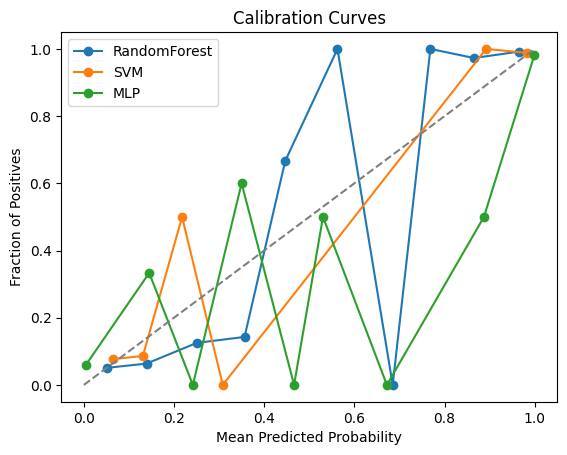

In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load your dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/another_dementia_dataset (1).csv")

# Drop unnecessary ID columns
df = df.drop(columns=["Subject ID", "MRI ID", "Visit"])

# Encode target (Converted treated as Demented)
df["Group"] = df["Group"].map({"Nondemented":0, "Demented":1, "Converted":1})

# Define features and target
y = df["Group"].values.astype(int)
X = df.drop("Group", axis=1)

num_features = ["Age","EDUC","SES","MMSE","CDR","MR Delay","eTIV","nWBV","ASF"]
cat_features = ["M/F","Hand"]

# ======================================
# STEP 2: Helper Functions
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []
oof_preds = {name: np.zeros(len(y)) for name in ml_models.keys()}
oof_probas = {name: np.zeros(len(y)) for name in ml_models.keys()}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation inside fold ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # Encode categoricals
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        y_proba = model.predict_proba(X_test_f)[:,1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        results_ml.append([name, fold, acc, auc, pr_auc])
        oof_preds[name][test_idx] = y_pred
        oof_probas[name][test_idx] = y_proba

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])
summary_ml = results_ml.groupby("Model")[["Accuracy","ROC-AUC","PR-AUC"]].mean()

print("=== ML Models Performance (CV mean) ===")
print(summary_ml)

# ======================================
# STEP 4: Stratified CV for DL models
# ======================================
results_dl = []
oof_preds_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}
oof_probas_dl = {"HNN": np.zeros(len(y)), "CNN+Transformer": np.zeros(len(y))}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # === Imputation & scaling ===
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()

    X_train_num = imputer.fit_transform(X_train[num_features])
    X_test_num = imputer.transform(X_test[num_features])

    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[cat_features].fillna(X_train[cat_features].mode().iloc[0]))
    X_test_cat  = ohe.transform(X_test[cat_features].fillna(X_train[cat_features].mode().iloc[0]))

    X_train_f = np.hstack([X_train_num, X_train_cat])
    X_test_f  = np.hstack([X_test_num, X_test_cat])

    y_train_np, y_test_np = np.array(y_train), np.array(y_test)

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train_np, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_proba = hnn.predict(X_test_f).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["HNN", fold, acc, auc, pr_auc])
    oof_preds_dl["HNN"][test_idx] = y_pred
    oof_probas_dl["HNN"][test_idx] = y_proba

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train_np,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_proba = cnn_tr.predict(np.expand_dims(X_test_f,-1)).ravel()
    y_pred = (y_proba>0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    results_dl.append(["CNN+Transformer", fold, acc, auc, pr_auc])
    oof_preds_dl["CNN+Transformer"][test_idx] = y_pred
    oof_probas_dl["CNN+Transformer"][test_idx] = y_proba

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","ROC-AUC","PR-AUC"])
summary_dl = results_dl.groupby("Model")[["Accuracy","ROC-AUC","PR-AUC"]].mean()

print("=== DL Models Performance (CV mean) ===")
print(summary_dl)

# ======================================
# STEP 5: Calibration & Brier Scores
# ======================================
calibration_results = []

for name in ml_models.keys():
    brier = brier_score_loss(y, oof_probas[name])
    calibration_results.append([name, brier])

for name in oof_preds_dl.keys():
    brier = brier_score_loss(y, oof_probas_dl[name])
    calibration_results.append([name, brier])

calibration_results = pd.DataFrame(calibration_results, columns=["Model","BrierScore"])
print("=== Brier Scores ===")
print(calibration_results)

# Example calibration curves
for name in ["RandomForest","SVM","MLP"]:
    prob_true, prob_pred = calibration_curve(y, oof_probas[name], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.title("Calibration Curves")
plt.show()


without smote


In [ ]:
# ======================================
# STEP 0: Setup
# ======================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ======================================
# STEP 1: Load dataset
# ======================================
df = pd.read_csv("/content/drive/MyDrive/thesis/another_dementia_dataset (1).csv")

# Drop unnecessary IDs
df = df.drop(columns=["Subject ID", "MRI ID", "Visit"])

# Encode target
df["Group"] = df["Group"].map({"Nondemented":0, "Demented":1, "Converted":1})  # Converted treated as Demented
y = df["Group"].values.astype(int)
X = df.drop("Group", axis=1).copy()

# Define feature groups
num_features = ["Age","EDUC","SES","MMSE","CDR","MR Delay","eTIV","nWBV","ASF"]
cat_features = ["M/F","Hand"]

# ======================================
# STEP 2: Helper Functions (DL models)
# ======================================
def build_hnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_cnn_transformer(input_dim):
    inputs = layers.Input(shape=(input_dim,1))
    x = layers.Conv1D(64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================
# STEP 3: Stratified CV for ML models (NO SMOTE)
# ======================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128,64), max_iter=300, random_state=42)
}

results_ml = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Numeric: impute + scale
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    # Categorical: impute + one-hot
    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # Train + evaluate (NO SMOTE)
    for name, model in ml_models.items():
        model.fit(X_train_f, y_train)
        y_pred = model.predict(X_test_f)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        results_ml.append([name, fold, acc, prec, rec, f1])

results_ml = pd.DataFrame(results_ml, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("=== ML Models Performance (mean over 5 folds) ===")
print(results_ml.groupby("Model").mean())

# ======================================
# STEP 4: Stratified CV for DL models (NO SMOTE)
# ======================================
results_dl = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y[train_idx], y[test_idx]

    # Imputation + scaling (same as ML)
    num_imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train[num_features]))
    X_test_num  = scaler.transform(num_imputer.transform(X_test[num_features]))

    cat_mode = X_train[cat_features].mode().iloc[0]
    X_train_cat = X_train[cat_features].fillna(cat_mode)
    X_test_cat  = X_test[cat_features].fillna(cat_mode)
    ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)

    # Combine
    X_train_f = np.hstack([X_train_num, X_train_ohe])
    X_test_f  = np.hstack([X_test_num,  X_test_ohe])

    # === HNN ===
    hnn = build_hnn(X_train_f.shape[1])
    es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
    hnn.fit(X_train_f, y_train, validation_split=0.2,
            epochs=30, batch_size=32, callbacks=[es], verbose=0)
    y_pred = (hnn.predict(X_test_f, verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["HNN", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

    # === CNN+Transformer ===
    cnn_tr = build_cnn_transformer(X_train_f.shape[1])
    cnn_tr.fit(np.expand_dims(X_train_f,-1), y_train,
               validation_split=0.2, epochs=30, batch_size=32,
               callbacks=[es], verbose=0)
    y_pred = (cnn_tr.predict(np.expand_dims(X_test_f,-1), verbose=0).ravel() > 0.5).astype(int)
    results_dl.append(["CNN+Transformer", fold,
                       accuracy_score(y_test, y_pred),
                       precision_score(y_test, y_pred, zero_division=0),
                       recall_score(y_test, y_pred, zero_division=0),
                       f1_score(y_test, y_pred, zero_division=0)])

results_dl = pd.DataFrame(results_dl, columns=["Model","Fold","Accuracy","Precision","Recall","F1"])
print("\n=== DL Models Performance (mean over 5 folds) ===")
print(results_dl.groupby("Model").mean())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


=== ML Models Performance (mean over 5 folds) ===
              Fold  Accuracy  Precision    Recall        F1
Model                                                      
GaussianNB     2.0  0.943676   0.976200  0.907057  0.939588
KNN            2.0  0.908757   0.967189  0.841291  0.898670
MLP            2.0  0.935712   0.956557  0.912613  0.932246
RandomForest   2.0  0.951784   0.982571  0.918168  0.948207
SVM            2.0  0.946414   0.988143  0.901652  0.942154



=== DL Models Performance (mean over 5 folds) ===
                 Fold  Accuracy  Precision    Recall        F1
Model                                                         
CNN+Transformer   2.0  0.740180   0.766067  0.693544  0.722415
HNN               2.0  0.951748   0.988285  0.912462  0.947788
